## Feature Selection Demo using Scikit -- PIMA Indians Diabetes Dataset

In this tutorial, I will use the "PIMA Indians Diabetes" dataset, where all patients are females at least 21 years old of Pima Indian heritage.

The classification task is to predict whether an individual has diabetes from the following features:
1. Pregnancies: Number of times pregnant 
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. BloodPressure: Diastolic blood pressure (mm Hg) 
4. SkinThickness: Triceps skin fold thickness (mm) 
5. Insulin: 2-Hour serum insulin (mu U/ml) 
6. BMI: Body mass index (weight in kg/(height in m)^2) 
7. DiabetesPedigreeFunction: Diabetes pedigree function 
8. Age: (years) 
9. Outcome: Class variable (0 or 1) 

## Utility Functions & Imports

In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#See bmes.ahmet/README.TXT for setting up BMESAHMETDIR environment variable.
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes

def printfileheadtruncated(file, N):
    from itertools import islice
    with open(file) as f:
        for line in islice(f, 3):
            if len(line)>80: print(line[0:80]+' ...')
            else: print(line.rstrip())


#perform four-fold cross-validation of the method
def crossvalidate(classifier,X,T):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(classifier, X, T, cv=4)
    print('--- 4-fold cross-validation accuracy: %%%.1f (+/-%.1f)' % (scores.mean()*100,scores.std()*100))


from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#classifier = DecisionTreeClassifier();

from sklearn.svm import SVC
classifier = SVC(kernel='linear')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download data file(s)

In [54]:
datafile = bmes.datadir() + '/pima-indians-diabetes.data';
bmes.downloadurl('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv',datafile);
print('--- First 5 lines of data file:')
printfileheadtruncated( datafile, 5 )

--- First 5 lines of data file:
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1


## Load data

In [55]:
import pandas, numpy
names = ['numpregnancies', 'glucose', 'diastolic', 'tricepskin', 'insulin', 'bmi', 'pedigree', 'age', 'hasdiabetes'];
data = pandas.read_csv(datafile, names=names);
print('--- First 5 rows of data:')
data.head(5)

--- First 5 rows of data:


,numpregnancies,glucose,diastolic,tricepskin,insulin,bmi,pedigree,age,hasdiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [56]:
X = data.values[:,:-1];
T = data.values[:,-1];
names=names[:-1]

## Perform Classification using all features

In [57]:
crossvalidate(classifier, X, T)

--- 4-fold cross-validation accuracy: %76.3 (+/-1.7)


## Select Features using Filters

For the list of available filters, see:
http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [58]:
from sklearn.feature_selection import (SelectKBest, chi2)

# Select top 3 features.
selector = SelectKBest(chi2, k=3)
selector.fit(X, T)

print('--- Scores of the features:')
sortedscores,sortednames = zip(*sorted(zip(selector.scores_,names), reverse=True))
for name, score in zip(sortednames,sortedscores):
    print('{:<14}'.format(name) + ': ' + str(round(score,1)));


--- Scores of the features:
insulin       : 2175.6
glucose       : 1411.9
age           : 181.3
bmi           : 127.7
numpregnancies: 111.5
tricepskin    : 53.1
diastolic     : 17.6
pedigree      : 5.4


In [59]:
print('--- Data with only the top k features:')
subX = selector.transform(X)
subnames = selector.transform([names])[0]
pandas.DataFrame(data=subX, columns=subnames).head(5)

--- Data with only the top k features:


,glucose,insulin,age
0,148.0,0.0,50.0
1,85.0,0.0,31.0
2,183.0,0.0,32.0
3,89.0,94.0,21.0
4,137.0,168.0,33.0


In [60]:
# Perform classification with the selected features:
crossvalidate(classifier, selector.transform(X), T)

--- 4-fold cross-validation accuracy: %73.7 (+/-3.3)


## Select Features using Recursive Elimination

In [61]:
from sklearn.feature_selection import (RFECV)

# RFECV using the SVM classifier would take forever; let's use a faster method.
#quickclassifier = DecisionTreeClassifier()
from sklearn.linear_model import LogisticRegression
quickclassifier = LogisticRegression(solver='liblinear')
selector = RFECV(quickclassifier,cv=4,scoring='accuracy')

selector.fit(X, T)

print('--- Selected Features (%d):' % (selector.n_features_))
[names[i] for i in range(len(names)) if selector.get_support()[i]]

--- Selected Features (5):


['numpregnancies', 'glucose', 'diastolic', 'bmi', 'pedigree']

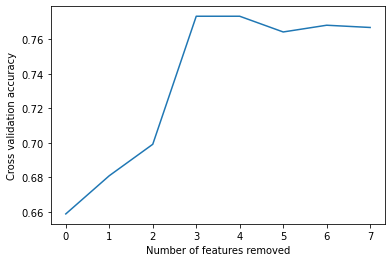

In [62]:
from pylab import *
xlabel("Number of features removed")
ylabel("Cross validation accuracy")
plot(range(0, len(selector.grid_scores_)), selector.grid_scores_)

In [63]:
crossvalidate(classifier, selector.transform(X), T)

--- 4-fold cross-validation accuracy: %76.7 (+/-1.3)


## Sequential Forward Selection

In [85]:
# mlxtend.feature_selection is an alternative library that can do forward/backward/floating selection.
bmes.pipinstall('mlxtend')

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)

from sklearn.feature_selection import (RFECV)

#quickclassifier = DecisionTreeClassifier()
from sklearn.linear_model import LogisticRegression
quickclassifier = LogisticRegression(solver='liblinear')
# I am using k_features to select all the way to the end, so I can manually visualize/decide how many features works best.
# You may want to avoid that if it takes too much time.
selector = SFS(quickclassifier,cv=4,scoring='accuracy',k_features=X.shape[1],forward=True)

selector.fit(X, T)

#features shown here are NOT ordered by their performance.
print('--- Selected Features (%d):' % (len(selector.k_feature_idx_)))
print(selector.k_feature_idx_)
[names[i] for i in selector.k_feature_idx_]

--- Selected Features (8):
(0, 1, 2, 3, 4, 5, 6, 7)


['numpregnancies',
 'glucose',
 'diastolic',
 'tricepskin',
 'insulin',
 'bmi',
 'pedigree',
 'age']

In [86]:
# get each added attribute and the resulting score
selectnames=[];
selectscores=[];
for x in selector.get_metric_dict().values():
    newnames=set([names[i] for i in x['feature_idx']]).difference(selectnames);
    selectnames.append(','.join(newnames));
    names = names + list(newnames);
    selectscores.append(x['avg_score'])

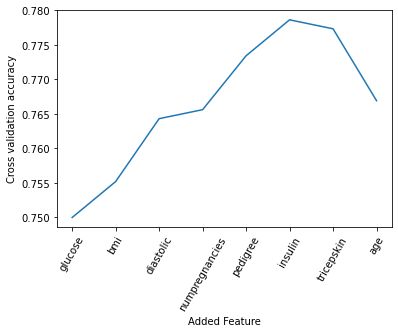

In [87]:
xlabel("Added Feature")
ylabel("Cross validation accuracy")
plot(range(1, len(selectscores)+1), selectscores)
import matplotlib.pyplot as plt
plt.xticks(range(1, len(selectscores)+1),selectnames,rotation=60);

#also see: mlxtend.plotting.plot_sequential_feature_selection() for extra plotting functionalities (stdev, etc).